In [194]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
import os,sys,inspect
import os
import joblib
import tensorflow as tf
import numpy as np
import h5py
import scipy.sparse.linalg as la
import scipy.sparse as sp
import scipy
import time
import pickle

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

import scipy.io as sio
import process_data
import graph

In [204]:
# Load Cora dataset
A, _, _, _, _, _ = process_data.load_data("cora")
A = scipy.sparse.csr_matrix(A, dtype=np.float32)
N, _ = A.shape
A.setdiag(0)
print("Cora -> Number of nodes =", N, "Number of edges =", A.nnz // 2, "\n")

(2708, 2708)
(2708, 1433)
Cora -> Number of nodes = 2708 Number of edges = 6632 



/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [205]:
def remove_random_nodes(A, r=0):
    if r<0 or r>1:
        print("Randomness level r not in range [0,1]")
        return

    M, _ = A.shape
    indexes = np.arange(M)
    

    num_to_keep = int(round((1-r) * M))
    indexes_to_keep = np.sort(np.random.choice(indexes, size=num_to_keep, replace=False, p=None))
    indexes_to_remove = np.setdiff1d(indexes, indexes_to_keep)

    indexes_to_keep_list = indexes_to_keep.tolist()
    
    A_reduced = A[indexes_to_keep_list, :]
    A_reduced = A_reduced[:, indexes_to_keep_list]   
    
    #A_reduced = sp.csr_matrix(A, dtype=np.float32)[indexes_to_keep_list, :] # Delete rows
    #A_reduced = sp.csr_matrix(A_reduced[:, indexes_to_keep_list], dtype=np.float32) # Delete columns

    return A_reduced, indexes_to_remove



def remove_specific_nodes(A, indexes_to_remove):
    M, _ = A.shape
    indexes = np.arange(M)
    
    indexes_to_keep = np.setdiff1d(indexes, indexes_to_remove)
    indexes_to_keep_list = indexes_to_keep.tolist()
    
    A_reduced = A[indexes_to_keep_list, :]
    A_reduced = A_reduced[:, indexes_to_keep_list]   
    
    #A_reduced = sp.csr_matrix(A, dtype=np.float32)[indexes_to_keep_list, :] # Delete rows
    #A_reduced = sp.csr_matrix(A_reduced[:, indexes_to_keep_list], dtype=np.float32) # Delete columns

    return A_reduced



"""### TEST ###
random_matrix = np.random.randint(0, 10, (10,10))
print(random_matrix)
A_new, removed = remove_random_nodes(random_matrix, 0.4)
print(removed)
print(A_new)"""

'### TEST ###\nrandom_matrix = np.random.randint(0, 10, (10,10))\nprint(random_matrix)\nA_new, removed = remove_random_nodes(random_matrix, 0.4)\nprint(removed)\nprint(A_new)'

In [206]:
def cayley_operator(L, r, scale, coefficients):
    s = np.linalg.norm(L.toarray(), 2)
    h = 2.0*scale/s
    N = L.shape[0]
    A = (h*L.toarray() - 1j*np.identity(N)) @ np.linalg.inv(h*L.toarray() + 1j*np.identity(N))
    AA = np.eye(A.shape[0])
    res = np.eye(A.shape[0])*coefficients[0]
    for k in range(r):
        res = res + 2.0* coefficients[k+1] * (AA @ A).real
        AA = AA @ A
    return res.real

In [207]:
L = graph.laplacian(A, normalized=True)
r = 12



coefficients_low = np.array([ 0.762957  , -0.55845029,  0.16243145,  0.04000212, -0.04137109,
                          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                          0.        ,  0.        ,  0.        ])*0.985 * 0.98
coefficients_mid = np.array([ 0.72875482, -0.14645678, -0.44402514,  0.13537618,  0.12523632,
                                0.00815884, -0.03310949, -0.01980383, -0.00557673,  0.01227825,
                                -0.00673004,  0.01079311, -0.00618034])*1.05*0.98

coefficients_hig = np.array([ 0.52028883,  0.213328  , -0.2321755 , -0.30423973, -0.11923577,
                              0.04332396,  0.10535769,  0.07566094,  0.02054968, -0.01731303,
                              -0.02321388, -0.00983169, -0.00594752])*0.96

In [209]:
randomness_range = np.arange(0, 0.95, 0.1) 
scales = np.linspace(1.0,0.5,10)
L_dif_3 = []
G_dif_3 = []
i = 0
np.random.seed(1)
for rand in randomness_range:
    A_prime, removed_indexes = remove_random_nodes(A, rand)
   

    L_prime = graph.laplacian(A_prime, normalized=True)
    L_second = remove_specific_nodes(L, removed_indexes)

    
    rel_err_L_prime_second = np.linalg.norm(L_prime.toarray() - L_second.toarray(), 'fro') / np.linalg.norm(L_prime.toarray(), 'fro')
    L_dif_3.append(rel_err_L_prime_second)


    F_low = cayley_operator(L, r, 1.0, coefficients_low)
    F_mid = cayley_operator(L, r, 1.0, coefficients_mid)
    F_hig = cayley_operator(L, r, 1.0, coefficients_hig)

    F_prime_low = cayley_operator(L_prime, r, scales[i], coefficients_low)
    F_prime_mid = cayley_operator(L_prime, r, scales[i], coefficients_mid)
    F_prime_hig = cayley_operator(L_prime, r, scales[i], coefficients_hig)

    F_second_low = remove_specific_nodes(F_low, removed_indexes)
    F_second_mid = remove_specific_nodes(F_mid, removed_indexes)
    F_second_hig = remove_specific_nodes(F_hig, removed_indexes)

    rel_err_F_prime_second_low = np.linalg.norm(F_prime_low - F_second_low, 'fro') / np.linalg.norm(F_prime_low, 'fro')
    rel_err_F_prime_second_mid = np.linalg.norm(F_prime_mid - F_second_mid, 'fro') / np.linalg.norm(F_prime_mid, 'fro')
    rel_err_F_prime_second_hig = np.linalg.norm(F_prime_hig - F_second_hig, 'fro') / np.linalg.norm(F_prime_hig, 'fro')
    G_dif_3.append(np.array([rel_err_F_prime_second_low, rel_err_F_prime_second_mid, rel_err_F_prime_second_hig]))

    print("Randomness level:", rand, "Errors:", G_dif_3[i])
    i = i+1

Randomness level: 0.0 Errors: [0. 0. 0.]
Randomness level: 0.1 Errors: [0.14185136 0.20270493 0.14207511]
Randomness level: 0.2 Errors: [0.22754814 0.30715366 0.24773739]
Randomness level: 0.30000000000000004 Errors: [0.28179379 0.37383228 0.37381298]
Randomness level: 0.4 Errors: [0.33419792 0.43261261 0.5256586 ]
Randomness level: 0.5 Errors: [0.37718659 0.47074294 0.71184665]
Randomness level: 0.6000000000000001 Errors: [0.41862974 0.50703782 0.95971787]
Randomness level: 0.7000000000000001 Errors: [0.46830995 0.52356298 1.35656213]
Randomness level: 0.8 Errors: [0.50241207 0.52161988 2.13075012]
Randomness level: 0.9 Errors: [0.54957641 0.48953184 3.30207432]


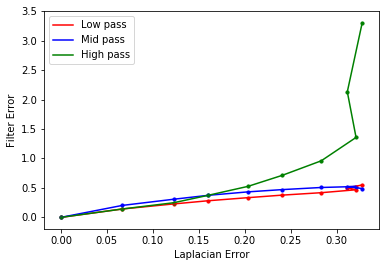

In [210]:
G_dif_3 = np.asarray(G_dif_3)

plt.plot(L_dif_3, G_dif_3[:,0], 'r')
plt.scatter(L_dif_3, G_dif_3[:,0], c='r', s=10)


plt.plot(L_dif_3, G_dif_3[:,1], 'b')
plt.scatter(L_dif_3, G_dif_3[:,1], c='b', s=10)


plt.plot(L_dif_3, G_dif_3[:,2], 'g')
plt.scatter(L_dif_3, G_dif_3[:,2], c='g', s=10)


labels = ["0%", "5%", "10%", "15%", "20%", "25%", "30%", "35%", "40%", "45%", "50%", "55%", "60%", "65%", "70%", "75%", "80%", "85%", "90%"]

"""i=0
for x,y in zip(L_dif_3, G_dif_3[:,1]):

    label = labels[i]
    i = i+1

    if i in [0, 1, 2, 3, 4, 6, 8, 10, 14]:
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
        

i=0      
for x,y in zip(L_dif_3, G_dif_3[:,0]):

    label = labels[i]
    i = i+1

    if i in [2, 3, 5, 7, 9, 13, 17]:
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-20), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

"""


legend = ["Low pass", "Mid pass", "High pass"]

plt.ylabel('Filter Error')
plt.xlabel('Laplacian Error')
plt.legend(legend)
#plt.title('(b)')
plt.savefig("./linear_stability_3.pdf", format='pdf')
plt.show()